In [2]:
print('What\'s up')

What's up


# Notebook Imports

In [137]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from collections import Counter
from wordcloud import WordCloud
from PIL import Image # will be used for converting image to greyscale and then to RGB values array

import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [199]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
BOLD_OPEN_SENS = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'
LIGHT_OPEN_SENS = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf'

# Reading Files 

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [7]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)






Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [8]:
def generate_squares(N):
    for number in range(N):
        yield number**2

In [9]:
for i in generate_squares(5):
    print(i, end='(--')

0(--1(--4(--9(--16(--

## Email body Extraction

In [10]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [11]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


In [15]:
ham_emails.shape

(3901, 2)

In [16]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire data frame is:', data.shape)
data.head()

Shape of entire data frame is: (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [17]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


In [18]:
pd.isnull(data).any()

MESSAGE     False
CATEGORY    False
dtype: bool

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5799 entries, 00001.7848dde101aa985090474a91ec93fcf0 to 01400.f897f0931e461e7b2e964d28e927c35e
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MESSAGE   5799 non-null   object
 1   CATEGORY  5799 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 135.9+ KB


# Data Cleaning: Checking for Missing values

In [20]:
data.MESSAGE.isnull().values.any()

False

In [21]:
# Check if there are empty emails (with string length of zero)
(data.MESSAGE.str.len() == 0).any()

True

In [22]:
(data.MESSAGE.str.len() == 0).sum()

3

In [23]:
data.MESSAGE.isnull().sum()

0

### Locate empty email

In [24]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [25]:
#data.index.get_loc('.DS_STORE') ON MAC

# Removing system file entries from DataFrame

In [26]:
data.drop(['cmds'], inplace=True)

In [27]:
(data.MESSAGE.str.len() == 0).any()

False

In [28]:
data.shape

(5796, 2)

# Add document ID'S to track emails in Dataset

In [29]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [30]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [31]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


In [32]:
data.shape

(5796, 3)

# Save to File using Pandas

In [33]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages visualized(Pie Charts)

In [34]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [35]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

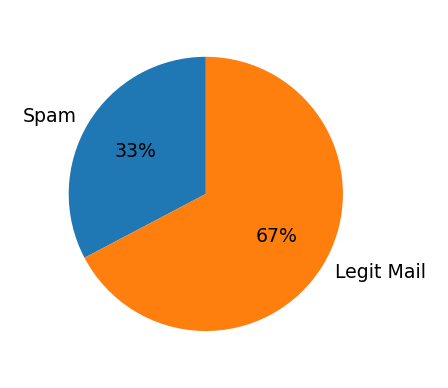

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(x=sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

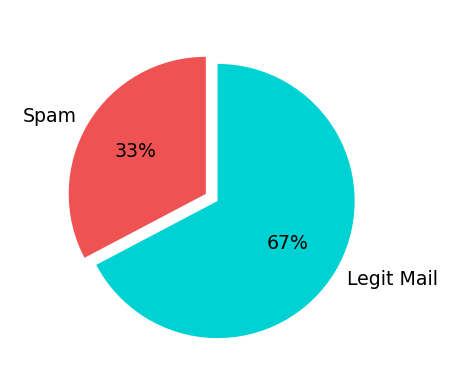

In [37]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ee5253', '#00d2d3']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(x=sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, colors=custom_colors
        , autopct='%1.0f%%', explode=[0, 0.1])
plt.show()

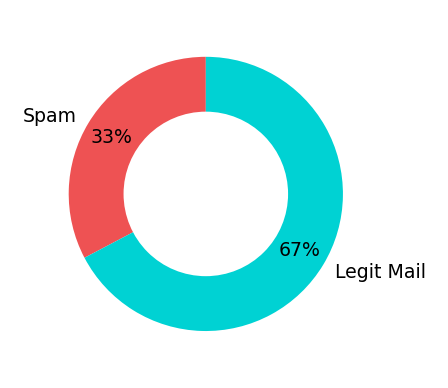

In [38]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ee5253', '#00d2d3']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(x=sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, colors=custom_colors
        , autopct='%1.0f%%', pctdistance=0.8)

#Draw Circle to impose on piechart to make it a donut chart.
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

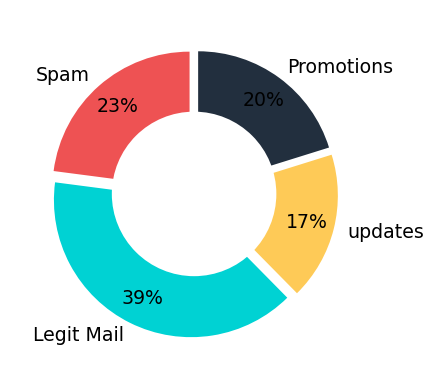

In [39]:
category_names = ['Spam', 'Legit Mail', 'updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#ee5253', '#00d2d3', '#feca57', '#222f3e']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(x=sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, colors=custom_colors
        , autopct='%1.0f%%', pctdistance=0.8, explode=offset)

#Draw Circle to impose on piechart to make it a donut chart.
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# NLP- Natural Language Processing

## Text Pre-Processing

In [40]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources(Tokenizer & Stopwords)

In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siphiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siphiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\siphiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\siphiwe\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [44]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing all stop words

In [45]:
stop_words =  set(stopwords.words('english'))

In [46]:
if 'this' in stop_words: print('Found it')
if 'hello' not in stop_words: print('Nope. Not in here')

Found it
Nope. Not in here


In [47]:
if not 'hello' in stop_words: print('Nope. Not in here')

Nope. Not in here


In [48]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []

for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [49]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)


['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [50]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)


['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML Tags from emails

In [51]:
data.at[2, 'MESSAGE']

soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')

print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [52]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

# Creating a function for email Processing.

In [53]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower()) #lowercase and tokenized
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha(): #removes stop words and punctuation
             filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [54]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [55]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser') 
    words = word_tokenize(soup.lower()) #lowercase and tokenized
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha(): #removes stop words and punctuation
             filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [56]:
clean_message(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

In [57]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser') 
    cleaned_text = soup.get_text()
    words = word_tokenize(cleaned_text.lower()) #lowercase and tokenized
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha(): #removes stop words and punctuation
             filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
    
    return filtered_words

In [58]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning and Tokenisation to all Messages

## Slicing Dataframes and Series & Creating Subsets

In [59]:
data.iat[0, 0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [2]:
data.iloc[0:3]

NameError: name 'data' is not defined

In [61]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [62]:
#clean_msg_no_html(data.MESSAGE.iloc[0:1])

In [63]:
#This was my take on the solution fyi(not as effective)

mail = []
n = 0

for i in range(3):
    mail.append(clean_msg_no_html(data.iat[n, 0]))
    n += 1
    

    print(n)
mail[0]

1
2
3


['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

In [64]:
#first_emails = data.MESSAGE.iloc[0:3]

#first_emails.apply(clean_message)

In [65]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_msg_no_html)
len(nested_list[0])

92

In [66]:
# flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

192

In [67]:
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [68]:
%%time

# using apply() all the messages in the DataFrame

nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\siphiwe\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 50.2 s


In [69]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice DataFrames

In [70]:
data[data.CATEGORY == 1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895],
           dtype='int64', name='DOC_ID', length=1896)

In [71]:
data[data.CATEGORY == 0].shape

(3900, 3)

In [72]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [73]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [74]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [75]:
type(nested_list) # with series you can use the .loc[] method and feed in the indices between []

pandas.core.series.Series

In [76]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [77]:
nested_list_ham.shape

(3900,)

In [78]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [79]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [80]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [81]:
nested_list_spam.shape

(1896,)

In [82]:
nested_list_spam.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [83]:
nested_list_spam.tail()

DOC_ID
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, dtype: object

In [84]:
nested_list_spam

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [85]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
len(flat_list_spam)

317499

In [86]:
spam_counts = Counter(flat_list_spam)

for word in flat_list_spam:
    spam_counts[word] +=1

spam_counts

Counter({'save': 1282,
         'life': 1286,
         'insur': 1092,
         'spend': 204,
         'quot': 434,
         'g': 158,
         'famili': 584,
         'financi': 830,
         'secur': 910,
         'import': 446,
         'ke': 12,
         'buy': 730,
         'simpl': 698,
         'afford': 130,
         'provid': 1104,
         'free': 5170,
         'access': 750,
         'best': 1264,
         'compani': 2190,
         'lowest': 306,
         'rate': 1484,
         'fast': 380,
         'money': 3082,
         'let': 660,
         'us': 2796,
         'help': 1538,
         'get': 3828,
         'start': 1276,
         'ue': 6,
         'countri': 710,
         'new': 2248,
         'coverag': 104,
         'hundr': 546,
         'even': 1056,
         'usand': 2,
         'dollar': 932,
         'request': 752,
         'lifequot': 2,
         'servic': 1930,
         'take': 1262,
         'less': 534,
         'minut': 636,
         'complet': 1034,
         

In [87]:
spam_counts.most_common(10)

[('http', 6194),
 ('email', 6180),
 ('free', 5170),
 ('click', 4116),
 ('receiv', 3978),
 ('list', 3942),
 ('get', 3828),
 ('pleas', 3704),
 ('busi', 3584),
 ('order', 3492)]

In [88]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
len(flat_list_ham)

442061

In [89]:
%%time

ham_counts = Counter(flat_list_ham)

for word in flat_list_ham:
    ham_counts[word] +=1

len(ham_counts)

Wall time: 346 ms


20815

In [90]:
ham_counts.most_common(10)

[('http', 15126),
 ('use', 7266),
 ('list', 5760),
 ('one', 4746),
 ('get', 4572),
 ('mail', 4510),
 ('would', 4006),
 ('like', 3862),
 ('messag', 3698),
 ('work', 3600)]

In [91]:
%%time
# Instructor solution
flat_list_ham = [item for sublist in nested_list_ham for item in sublist] #flatten nested list
normal_words = pd.Series(flat_list_ham).value_counts() # Creating series that stores words and their value counts(number of reps)
normal_words.shape #This gives you the number of normal words

Wall time: 207 ms


(20815,)

In [92]:
normal_words[:10] # This will give you the first 10 words on the list that is already sorted from high to low.

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [93]:
%%time
# Instructor solution
flat_list_spam = [item for sublist in nested_list_spam for item in sublist] #flatten nested list
spammy_words = pd.Series(flat_list_spam).value_counts() # Creating series that stores words and their value counts(number of reps)
spammy_words.shape #This gives you the number of normal words

Wall time: 154 ms


(13242,)

In [94]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating Word Cloud

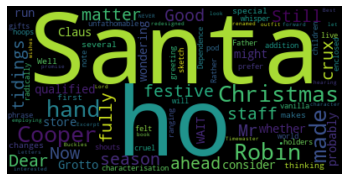

In [95]:
wordcloud = WordCloud().generate(email_body)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [96]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [97]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [98]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [99]:
word_list = [''.join(word) for word in example_corpus] #list comprehension
novel_as_string = ' '.join(word_list)

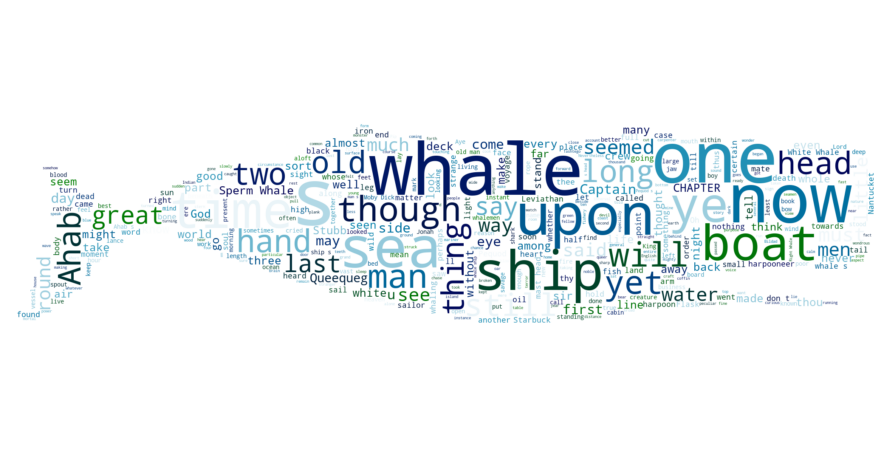

In [100]:
icon = Image.open(WHALE_FILE) #Opening the image file
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) #
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #o

wordcloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')
wordcloud.generate(novel_as_string)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [101]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')

In [102]:
word_list_two = [''.join(word) for word in hamlet_corpus] #list comprehension
hamlet_as_string = ' '.join(word_list_two)

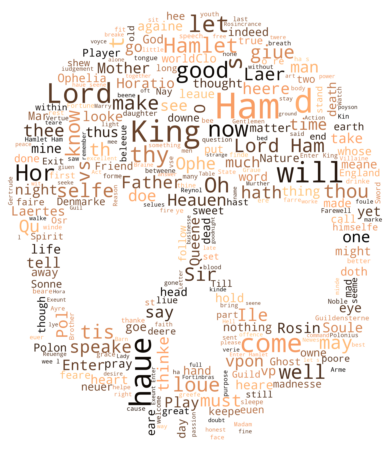

In [103]:
skull_icon = Image.open(SKULL_FILE) #Opening the image file
image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255, 255, 255)) #
image_mask.paste(skull_icon, box=skull_icon)

rgb_array = np.array(image_mask) 

wordcloud = WordCloud(mask=rgb_array, background_color='white', max_words=300, colormap='copper')
wordcloud.generate(hamlet_as_string)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [104]:
example_corpus_three = nltk.corpus.shakespeare.words('hamlet.xml')

In [105]:
type(example_corpus_three)

list

In [106]:
novel_as_string_three = ' '.join(word_list_two)

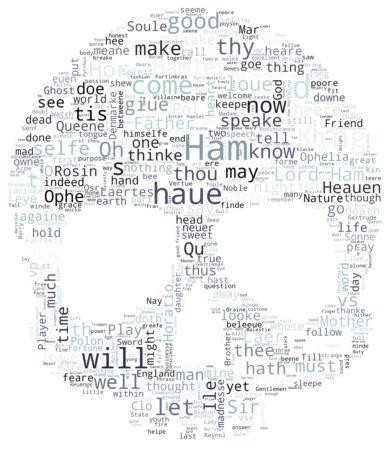

Wall time: 37.3 s


In [107]:
%%time

icon = Image.open(SKULL_FILE) #Opening the image file
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) #
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) 

wordcloud = WordCloud(mask=rgb_array, background_color='white', max_words=600, colormap='bone')
wordcloud.generate(novel_as_string_three)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud for Ham and Spam messages

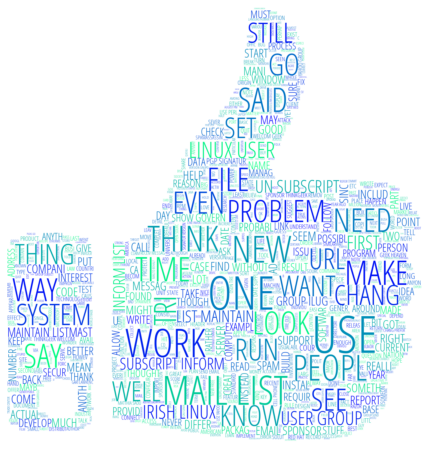

In [108]:
icon = Image.open(THUMBS_UP_FILE) #Opening the image file
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) #
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) 

ham_str = ' '.join(flat_list_ham)

wordcloud = WordCloud(font_path=LIGHT_OPEN_SENS, mask=rgb_array, background_color='white', max_words=1000, colormap='winter')
wordcloud.generate(ham_str.upper())
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

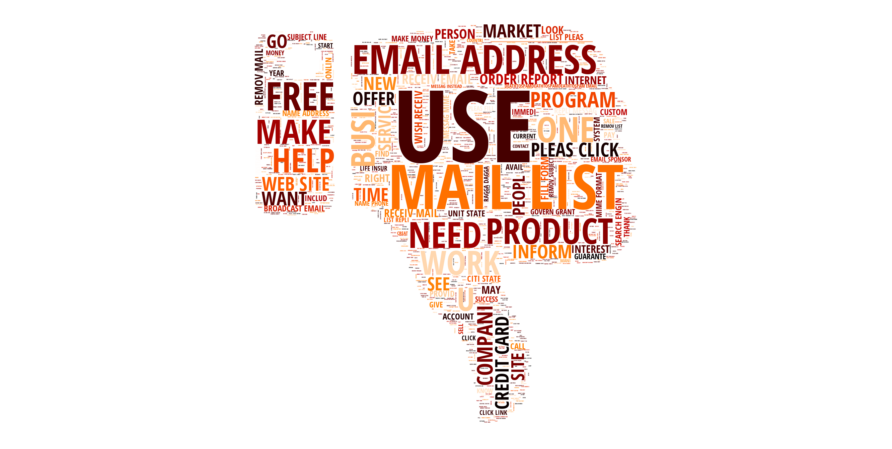

In [109]:
icon = Image.open(THUMBS_DOWN_FILE) #Opening the image file
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255)) #
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) 

spam_str = ' '.join(flat_list_spam)

wordcloud = WordCloud(font_path=BOLD_OPEN_SENS, margin=3, mask=rgb_array, background_color='white', max_words=2000, 
                      colormap='gist_heat', max_font_size=300)
wordcloud.generate(spam_str.upper())
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulory & Dictionary 

In [110]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\siphiwe\Anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [111]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print(unique_words.shape[0]) # this will print out the number of unique words in this series.
unique_words.head() # this will print out the top five words on the series.

27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [112]:
# My solution to challenge.

#frequent_words = unique_words.iloc[0: 2500] 
#print('Top 10 words:\n', frequent_words[:10])

# Instructor's solution to challenge.

frequent_words = unique_words[0: VOCAB_SIZE] 
print('Top 10 words:\n', frequent_words[:10])

Top 10 words:
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


In [113]:
frequent_words.shape

(2500,)

## Create Vocabulary DataFrame with a WORD_ID

In [150]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the vocabulary as a CSV File

In [152]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [151]:
vocab.VOCAB_WORD

WORD_ID
0             http
1              use
2             list
3            email
4              get
           ...    
2495       subsequ
2496     congratul
2497    filesystem
2498         rapid
2499        missil
Name: VOCAB_WORD, Length: 2500, dtype: object

In [153]:
# My solution

def word_checker(word):
    for words in vocab.VOCAB_WORD:
        if words == word:
            return True
        else:
            return False
word_checker('brewery')

False

In [154]:
#Instructor solution

'fun' in set(vocab.VOCAB_WORD)


True

In [119]:
len(nested_list)

5796

# My solution to coding challenge in vid:120

In [120]:
email_lengths = []
for n in range(0, len(nested_list)):
    email_lengths.append(len(nested_list[n]))

print('Longest words in the email:',max(email_lengths))
print('Position of Longest email:', email_lengths.index(7671))
print('Stemmed list of words from longest email:', nested_list[5775])

Longest words in the email: 7671
Position of Longest email: 5775
Stemmed list of words from longest email: ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', '

In [121]:
data.MESSAGE[5775] #Longest email from DataFrame.

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Instructor's solution to challenge in Vid:120

In [122]:
#Using For loop

clean_email_lengths = []

for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [123]:
# Using List comprehension

clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list] # This is definitely quicker.
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [124]:
print('Email position in the list and the data DataFrame:', np.argmax(clean_email_lengths))

Email position in the list and the data DataFrame: 5775


In [125]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [126]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE'] #This was different from how I did it.

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features and a Sparse Matrix

### Creating a DataFrame with one word per Column

In [129]:
type(stemmed_nested_list)

pandas.core.series.Series

In [130]:
type(stemmed_nested_list.tolist())

list

In [134]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
5791,http,bizarr,collect,stuf,anim,could,fetch,sold,cornwal,museum,...,None,None,None,None,None,None,None,None,None,None
5792,care,use,one,also,realli,cute,thing,japanes,av,girl,...,None,None,None,None,None,None,None,None,None,None
5793,sm,skip,montanaro,write,jeremi,put,anoth,way,interest,hear,...,None,None,None,None,None,None,None,None,None,None
5794,mark,hammond,like,given,zodb,sound,attract,would,packag,hundr,...,None,None,None,None,None,None,None,None,None,None
5795,hi,probabl,use,whatsoev,also,problem,regard,nvidia,two,machin,...,None,None,None,None,None,None,None,None,None,None


In [132]:
word_columns_df.shape

(5796, 7671)

### Splitting the data into a training and testing dataset.

In [135]:
target = data.CATEGORY
features = word_columns_df

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state = 42)

In [140]:
print('number of training samples:', X_train.shape[0])
print('fraction of training set:', len(X_train)/len(features))
print('fraction of test set:', X_test.shape[0]/features.shape[0])

number of training samples: 4057
fraction of training set: 0.6999654934437544
fraction of test set: 0.3000345065562457


In [168]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.index[0]

4844

In [172]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [175]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'pci', 'ximian', 'render', 'asian', 'quarter', 'subsequ', 'congratul',
       'filesystem', 'rapid', 'missil'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [176]:
word_index.get_loc('url')

109

In [179]:
#df=dataframe, indexed_words=WORD_ID indexes, labels=y values(data.CATEGORY)

def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as DataFrame
    
    df: A DataFrame with words in the columns  with a document id as an index(x_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series(y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
        
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [180]:
%%time

sparse_train = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 17min 32s


In [182]:
sparse_train[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1239
2,0,4844,1,502
3,0,4844,1,308
4,0,4844,1,254


In [183]:
sparse_train[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429226,1,860,1,47
429227,1,860,1,1430
429228,1,860,1,26
429229,1,860,1,21
429230,1,860,1,126


In [184]:
sparse_train.shape

(429231, 4)

### Combine occurence with the Pandas groupby() Method 

In [185]:
train_grouped = sparse_train.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [186]:
vocab.at[2, 'VOCAB_WORD']

'list'

In [187]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [188]:
train_grouped = train_grouped.reset_index()

In [189]:
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [191]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258358,5795,2038,0,1
258359,5795,2040,0,2
258360,5795,2265,0,1
258361,5795,2335,0,1
258362,5795,2363,0,1


In [194]:
vocab.at[2040, 'VOCAB_WORD']

'swap'

In [193]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [195]:
train_grouped.shape

(258363, 4)

### Save Training Data as .txt File

In [197]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [198]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [200]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 7min 15s


In [210]:
sparse_test_df.shape

(203378, 4)

In [201]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [202]:
test_grouped = test_grouped.reset_index()

In [203]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [204]:
test_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [221]:
test_grouped.DOC_ID

0            8
1            8
2            8
3            8
4            8
          ... 
117774    5793
117775    5793
117776    5793
117777    5793
117778    5793
Name: DOC_ID, Length: 117779, dtype: int64

In [208]:
vocab.at[2378, 'VOCAB_WORD']

'spambay'

In [211]:
test_grouped.shape

(117779, 4)

In [232]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [236]:
len(test_doc_ids)

1724

In [235]:
len(X_test)

1739